Model Evaluation

- indentify if model is stationary or non stationary
- parameter estimation of model
-diagnostic checking- is model adequate?
-choosing best model





 *first let's roll out that fantastic ecosystem of data-centric python packages to make importing and analyzing the data much easier!*


In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import pickle
## from SCRIPT.eval_tools import *
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from matplotlib import rcParams
import folium
import json
from urllib.request import urlopen
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

In [2]:
pip install scripts

Note: you may need to restart the kernel to use updated packages.


 quick check of versions numpy and pandas

In [3]:
print('np:{}'.format(np.__version__))
print('pd:{}'.format(pd.__version__))

np:1.21.5
pd:1.3.5


 Next let's load some data! 🥒
 * 1 first let's take the byte stream and load it and unpickle it
 * 2  then use datetime index.date  to output an index object containing the date values
 * 3 next convert the column into a string
 * 4 create new dataframe
 * 5 and finally select zip codes (create an array)

In [3]:
#1
with open('pickle/timeseries_condo_subset_percent.pkl', 'rb') as fp:
    subset_percent = pickle.load(fp)

In [4]:
#2
subset_percent.index = pd.DatetimeIndex(subset_percent.index.values, freq='infer')

In [5]:
#3
subset_percent.columns = subset_percent.columns.astype(str)

In [6]:
#4
trdf_percent = subset_percent.iloc[:-40]

In [7]:
trdf_percent.head()

,95823,95630,95624,95758,95608,95828,95670,95843,95610,95822,...,95825,95632,95842,95662,95834,95864,95841,95814,95811,95683
2008-02-01,-1.661410,-1.510573,-3.946833,-3.543212,-1.951003,-1.675978,-1.834070,-2.216788,-1.310047,-1.117577,...,-2.171396,-1.386765,-2.601227,-0.432935,-2.146000,-1.886570,-1.802196,-1.895604,-1.543989,-2.931731
2008-03-01,-2.139399,-2.662771,-4.001361,-3.768685,-3.107064,-3.679068,-2.939299,-4.761657,-2.967652,-3.070655,...,-3.228813,-1.424909,-4.481063,-2.072756,-3.434646,-2.656758,-3.730638,-4.248985,-2.774016,-4.179664
2008-04-01,-1.637104,-2.137456,-3.028208,-3.178854,-2.352817,-3.734514,-2.694146,-3.234903,-2.241481,-1.980032,...,-2.409676,-3.133435,-3.647895,-2.925830,-3.675737,-2.249487,-3.030027,-3.327600,-1.652859,-2.764905
2008-05-01,-3.183426,-1.859358,-3.268965,-4.161465,-2.061474,-4.287412,-2.055039,-3.516029,-2.085231,-2.292874,...,-1.856357,-3.342178,-3.548667,-4.252559,-3.743610,-1.461723,-2.035399,-1.994672,-1.090838,-2.286031
2008-06-01,-3.615116,-1.997343,-2.878963,-3.645155,-2.393563,-3.795131,-2.369481,-2.737991,-1.644106,-1.278214,...,-2.274067,-3.787357,-2.163443,-2.151209,-3.490498,-1.501673,-2.418063,-0.586013,-0.300809,-2.816718


In [8]:
#5
select_zipcode = ['95823', '95630', '95811', '95814', '95841']

 let's look at the range of data

In [9]:
trdf_percent.describe().T.describe()[['mean', 'min', 'max']]

,mean,min,max
count,28.000000,28.000000,28.000000
mean,0.086871,-5.093235,4.137062
std,0.082749,4.229689,0.782597
min,-0.154969,-26.049119,2.607537
25%,0.054082,-4.828586,3.808619
50%,0.098951,-4.170564,3.982257
75%,0.151979,-3.728405,4.546911
max,0.199149,-2.662771,6.181477


 now divide up the dataFrame

In [10]:
zip_1 = select_zipcode[0]
sel_df1 = subset_percent[zip_1]
zip_2 = select_zipcode[1]
sel_df2 = subset_percent[zip_2]
zip_3 = select_zipcode[2]
sel_df3 = subset_percent[zip_3]
zip_4 = select_zipcode[3]
sel_df4 = subset_percent[zip_4]
zip_5 = select_zipcode[4]
sel_df5 = subset_percent[zip_5]

 baseline

 to evaluate the performance of each forecasting model (SARIMA and LSTM I used root-mean-square error (rmse)

 RSME = *root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. The RMSD represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences*

* 1 first defining function. the sqrt() function is an inbuilt function that returns the square root of any number. 
* 2 next we will get the baseline 
* 3 create df (dataFrame) 
* and 4 make baseline off of historical average

In [11]:
#1
def RMSE(y_true, y_pred):
    return sqrt(MSE(y_true, y_pred))

In [12]:
baseline_RMSE = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    pred = df.shift()[-40:]
    y_test = df[-40:]
    baseline_RMSE.append(RMSE(y_test, pred))

In [13]:
results = pd.DataFrame(baseline_RMSE, columns = ['baseline'])

In [17]:
baseline_RMSE2 = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    y_train = [np.mean(df[:-40])] * 40
    y_test = df[-40:]
    baseline_RMSE2.append(RMSE(y_test, pred))

In [18]:
results['historic_avg'] = baseline_RMSE2

 so let's evaluate the SARIMA model

 1. rolling average

 *Time Series Plot is used to observe various trends in the dataset over a period of time. In such problems, the data is ordered by time and can fluctuate by the unit of time considered in the dataset (day, month, seconds, hours, etc.). When plotting the time series data, these fluctuations may prevent us to clearly gain insights about the peaks and troughs in the plot. So to clearly get value from the data, we use the rolling average concept to make the time series plot.*

 we will use zip code 1  (95630/folsom ca) and plot the moving average 

In [19]:
def plot_moving_avg(series, window, zipcode = ''):
    rolling_mean = series.rolling(window = window).mean()
    rolling_sd = series.rolling(window = window).std()
    plt.figure(figsize = (6, 4))
    plt.plot(series, label = 'Actual Values', lw = 2)    
    plt.plot(rolling_mean, '--', label = 'Rolling Mean', lw = 2)
    plt.plot(rolling_sd, '--', label = 'Rolling St. Dev', lw = 2)
    plt.legend()
    plt.ylabel('Percentage Increase')
    plt.xlabel('Year')
    plt.title(f'{window} months rolling trend ({zipcode})')
    plt.show()
    

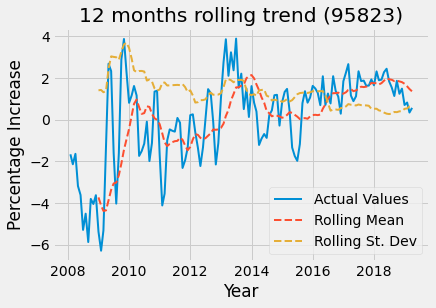

In [20]:
plot_moving_avg(sel_df1[:-40], 12, zip_1)

  2. stationarity or trend-stationarity? with dickey_fuller
  - again we will use zip code 1 (95630/folsom ca) 
  -*dickey_fuller tests the null hypothesis that a unit root is present in an autoregressive time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.* 

In [21]:
def run_dickey_fuller(series, title):
    result = adfuller(series)
    p = result[1]
    if p < 0.05:
        print(f'Null Rejected (p = {round(p, 4)}). {title} time series is stationary')
    else: 
        print(f'Failed to reject the null (p = {round(p, 4)}). {title} time series is not stationary')

In [22]:
run_dickey_fuller(sel_df1[:-40], zip_1)

Null Rejected (p = 0.0066). 95823 time series is stationary


 3 plot decomposition

- again we will use zip code 1 (95630/folsom ca)

- *Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components. Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting*


In [23]:
def plot_decomposition(series, zipcode = ''):
    rcParams['figure.figsize'] = 12,6
    seasonal_decompose(series).plot()
    plt.xlabel(f'year ({zipcode})')
    plt.show()

    

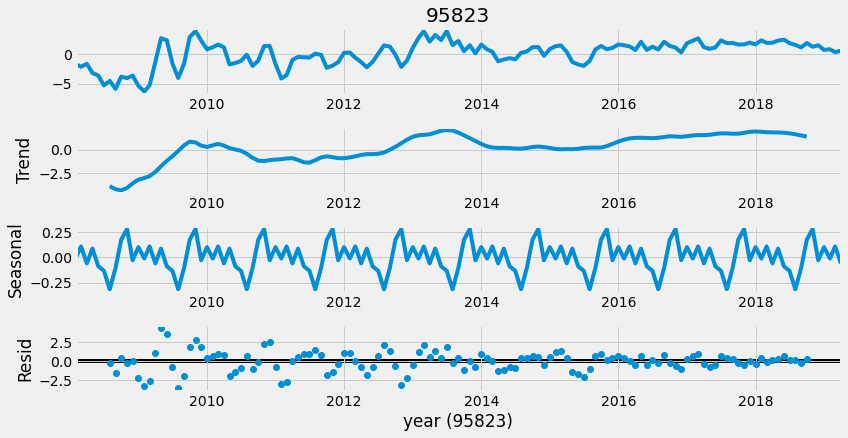

In [24]:
plot_decomposition(sel_df1[:-40], zip_1)

 4. ACF and PACF

- These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

- *ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an acf plot.*

- *PACF is a  partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.*

- again we will use zip code 1 (95630/folsom ca)


C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


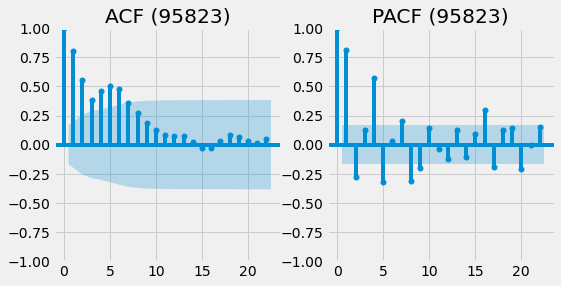

In [25]:
def def_acf_pacf(series, zipcode):
    plt.figure(figsize = (8, 4))
    ax1 = plt.subplot(1, 2, 1)
    plot_acf(series, ax = ax1, alpha = 0.05)
    plt.title(f'ACF ({zipcode})')
    ax2 = plt.subplot(1, 2, 2)
    plot_pacf(series, ax = ax2, alpha = 0.05)
    plt.title(f'PACF ({zipcode})')
    plt.show()


def_acf_pacf(sel_df1[:-40], zip_1)

 a basic time series plot

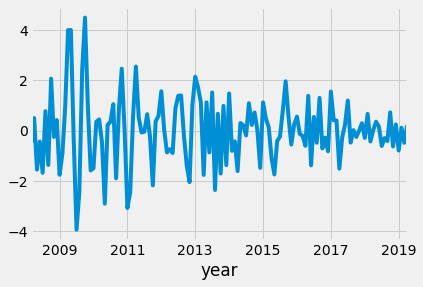

In [26]:
def plot_basic(series, xlabel = 'year', ylabel = '', title = ''):
     
    plt.figure(figsize = (6, 4))
    series.plot()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()



plot_basic(sel_df1[:-40].diff(1)[1:])

 Dickey_fuller
- last time (above) we ran " run_dickey_fuller(sel_df1[:-40], zip_1)". 
- Removing trend by differencing

In [27]:
run_dickey_fuller(sel_df1[:-40].diff(1)[1:], zip_1)

Null Rejected (p = 0.0004). 95823 time series is stationary


 5. AIC the akaike information criterion.

 - aic-  is a mathematical method for evaluating how well a model fits the data it was generated from. 
 - aic is calculated from:
 -the number of independent variables used to build the model.
 - the maximum likelihood estimate of the model (how well the model reproduces the data).
 - the best-fit model according to AIC is the one that explains the greatest amount of variation using the fewest possible independent variables.

let's find the best parameters (hyperparameters-defined below) that yield the lowest AIC

In [28]:
def find_sarima_param(df, max_range = 2, 
                      p = range(0, 2), 
                      d = range(0, 2),
                      q = range(0, 2),
                      s = 12, thresh = 500):
    '''find the best sarima params'''
    
    pdq = list(product(p, d, q))
    spdq = [x + (s,) for x in pdq]
    min_param = [None, None, thresh]

    for param in pdq:
        for sparam in spdq:
            try:
                mod = SARIMAX(df, order=param,
                              seasonal_order=sparam)
                results = mod.fit()

                if results.aic < min_param[2]: 
                    min_param[0] = param
                    min_param[1] = sparam
                    min_param[2] = results.aic
            except:
                continue
    print(f'pdq: {min_param[0]}, PDQS: {min_param[1]} - AIC: {round(min_param[2], 2)}')
    return min_param[0], min_param[1]


configure hyperparameters (above)

-trend elements

pdq=
- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.
-seasonal Elements

spdq=
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.

In [29]:
pdq, SPDQ = find_sarima_param(sel_df1[:-40])

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


pdq: (1, 0, 1), PDQS: (0, 1, 1, 12) - AIC: 442.61


 6 covariance matrix tests

In [30]:
sarima = SARIMAX(sel_df1[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model1 = sarima.fit()
print(sarima_model1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              95823   No. Observations:                  135
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -180.098
Date:                            Thu, 22 Sep 2022   AIC                            368.196
Time:                                    17:19:00   BIC                            378.961
Sample:                                02-01-2008   HQIC                           372.562
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5509      0.083      6.620      0.000       0.388       0.714
ma.L1          0.2559      0.102   


 so what's all the above saying? defining the matrix... free your mind!
* Ljung-Box (L1) (Q): is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero. Instead of testing randomness at each distinct lag, it tests the "overall" randomness based on a number of lags, and is therefore a portmanteau test.                 
*  Heteroskedasticity used in a linear regression model and assumes that the error terms are normally distributed. It tests whether the variance of the errors from a regression is dependent on the values of the independent variables.
* Jarque-Bera is a type of Lagrange multiplier test, is a test for normality.Specifically, the test matches the skewness and kurtosis of data to see if it matches a normal distribution.
* kurtosis is a measure that describes the shape of a distribution's tails in relation to its overall shape. apositive value tells you that you have heavy-tails (i.e. a lot of data in your tails
* skewness is the degree of asymmetry observed in a probability distribution.

Standard Deviation
* sigma2= One standard deviation, or one sigma, plotted above or below the average value on that normal distribution curve, would define a region that includes 68 percent of all the data points. Two sigmas above or below would include about 95 percent of the data

recieved warning:⚠️[1] Covariance matrix calculated using the outer product of gradients (complex-step).
 
 this is more like a "note" than a "warning". It's just letting you know how the covariance matrix was computed.

 7 sarima with plot_diagnostics
* plot_diagnostics( ), which function to ensure that none of the assumptions made by the model have been violated, and that there is no unusual behavior.

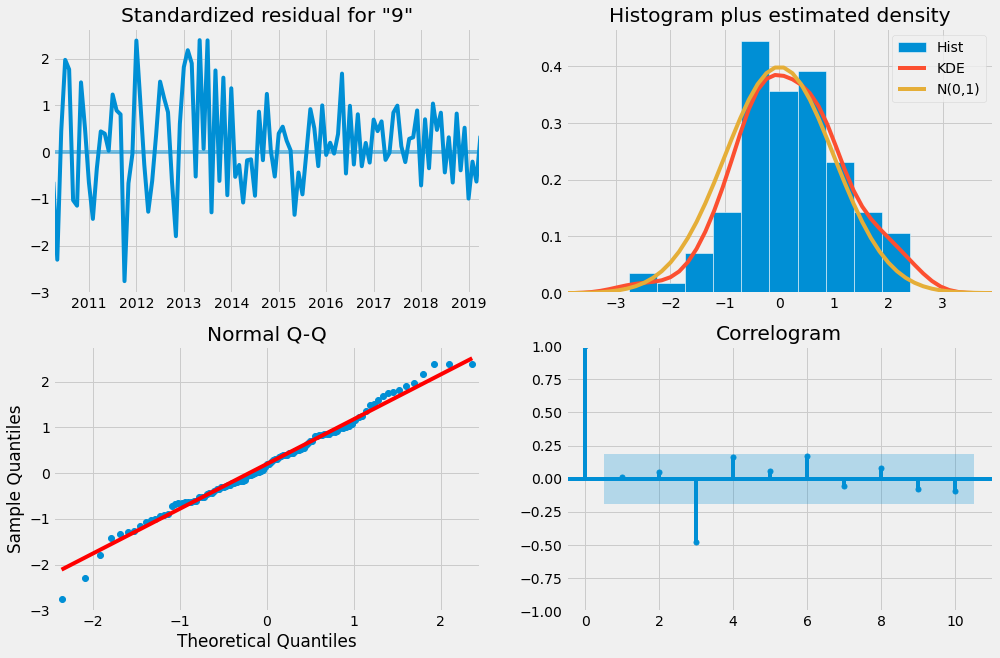

In [31]:
sarima_model1.plot_diagnostics(figsize = (15 ,10))
plt.show()

explanation of plots (above)
- TOP LEFT plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.
* TOP RIGHT we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.
* BOTTOM LEFT qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).
* BOTTOM RIGHT The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

 Concusion of plot_diagnostics above
by validating all the four points above, we can conclude that this model’s residuals are near normally distributed. This indicates we have found a well-fit model suitable for our dataset.

and finally we will calculate rmse based on rolling forcast

In [32]:
def rolling_forecast(df, pdq, SPDQ, term = 40):
    train = df[:-term]
    test = df[-term:]
    hist = list(train)
    pred = list()
    for term in range(len(test)):
        model = SARIMAX(hist, order = pdq, 
                        seasonal_order = SPDQ,enforce_stationarity=False) 
        fit = model.fit(disp=0)
        pred.append(fit.forecast()[0])
        hist.append(test[term]) 
    return train, test, hist, pred

In [33]:

def test_RMSE(df, pdq, SPDQ, term = 40, show = True):
    
    _, test, _, pred = rolling_forecast(df, pdq, SPDQ, term = term)
    
    if show:
        plt.figure(figsize=(8, 6))
        plt.plot(df, label='true')
        plt.plot(test.index, pred, label='Forecast')
        plt.xlabel('Date')
        plt.ylabel('Percent Increase')        
        plt.legend(loc='best')
        plt.title('Rolling Forecasting On Test Set')
        plt.show()
    return RMSE(test, pred)

 got; LinAlgError: LU decomposition error. ⚠️

 so let's check for nans

In [34]:
from scipy import linalg
print(linalg.lapack.dgetrf([np.nan]))
print(linalg.lapack.dgetrf([np.inf]))

(array([nan]), array([0], dtype=int32), 0)
(array([inf]), array([0], dtype=int32), 0)



error solved!  🎈 needed to add param  "enforce_stationarity=False" . No one on earth knows why either.

In [35]:
# got; LinAlgError: LU decomposition error. ⚠️
#added-enforce_stationarity=False) 
#model = SARIMAX(hist, order = pdq, 
                       #
    #seasonal_order = SPDQ, enforce_stationarity=False)
    
# What did this parameter do exactly? ...even the guy that suggested fix didn't know

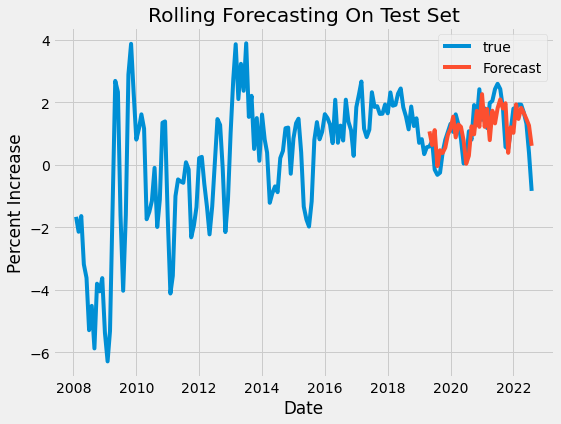

In [36]:
rmse_1 = test_RMSE(sel_df1, pdq, SPDQ)

now, let's do same for for zip 2 

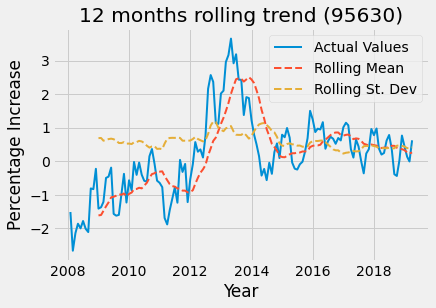

In [37]:
plot_moving_avg(sel_df2[:-40], 12, zip_2)

In [38]:
run_dickey_fuller(sel_df2[:-40], zip_2)

Failed to reject the null (p = 0.1891). 95630 time series is not stationary


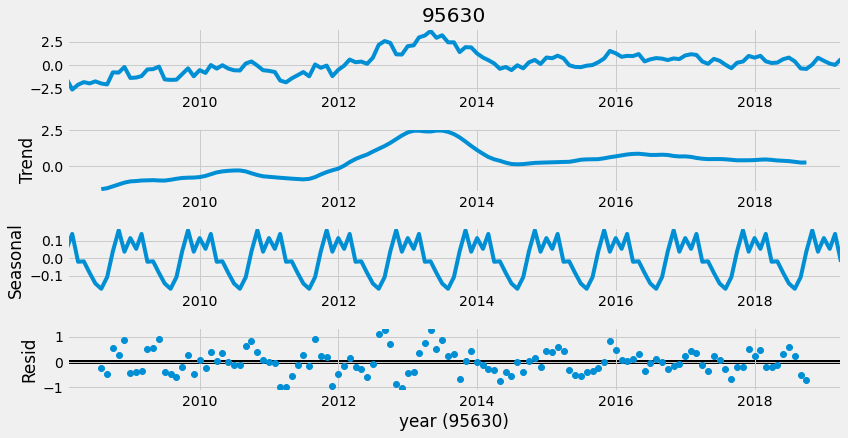

In [39]:
plot_decomposition(sel_df2[:-40], zip_2)

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


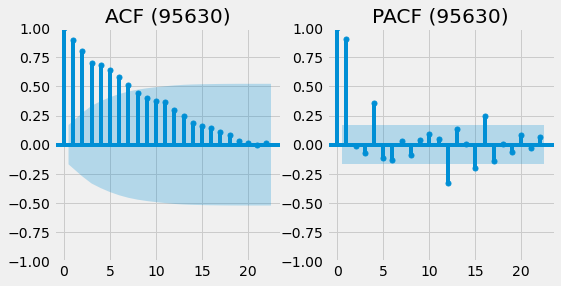

In [40]:
def_acf_pacf(sel_df2[:-40], zip_2)

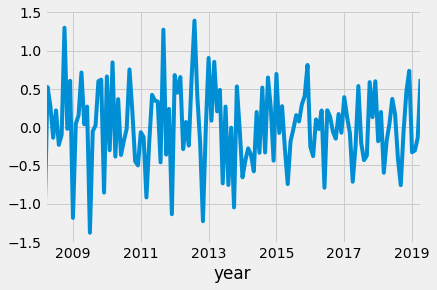

In [41]:
plot_basic(sel_df2[:-40].diff(1)[1:])

In [42]:
run_dickey_fuller(sel_df2[:-40].diff(1)[1:], zip_2)

Failed to reject the null (p = 0.086). 95630 time series is not stationary


In [43]:
pdq, SPDQ = find_sarima_param(sel_df2[:-40])

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


pdq: (1, 1, 1), PDQS: (0, 0, 0, 12) - AIC: 207.85


In [44]:
sarima = SARIMAX(sel_df2[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model2 = sarima.fit()
print(sarima_model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  95630   No. Observations:                  135
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -98.906
Date:                Thu, 22 Sep 2022   AIC                            203.811
Time:                        17:19:58   BIC                            212.460
Sample:                    02-01-2008   HQIC                           207.326
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7384      0.188     -3.933      0.000      -1.106      -0.370
ma.L1          1.6207      0.628      2.581      0.010       0.390       2.851
sigma2         0.0996      0.077      1.293      0.1

In [45]:
sarima = SARIMAX(sel_df2[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model2 = sarima.fit()
print(sarima_model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  95630   No. Observations:                  135
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -98.906
Date:                Thu, 22 Sep 2022   AIC                            203.811
Time:                        17:20:01   BIC                            212.460
Sample:                    02-01-2008   HQIC                           207.326
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7384      0.188     -3.933      0.000      -1.106      -0.370
ma.L1          1.6207      0.628      2.581      0.010       0.390       2.851
sigma2         0.0996      0.077      1.293      0.1

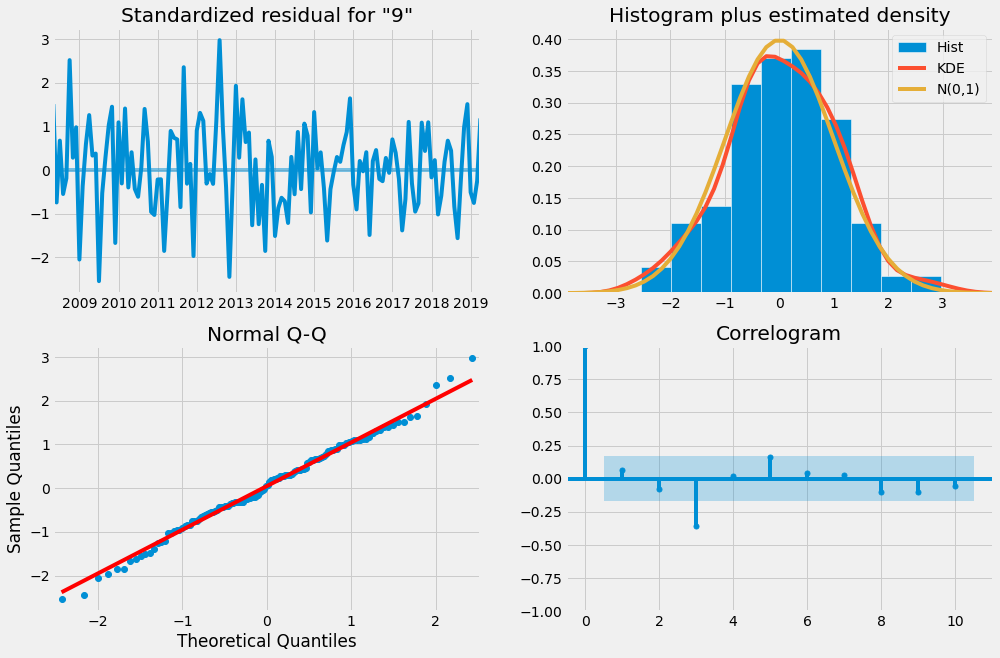

In [46]:
sarima_model2.plot_diagnostics(figsize = (15, 10))
plt.show()

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


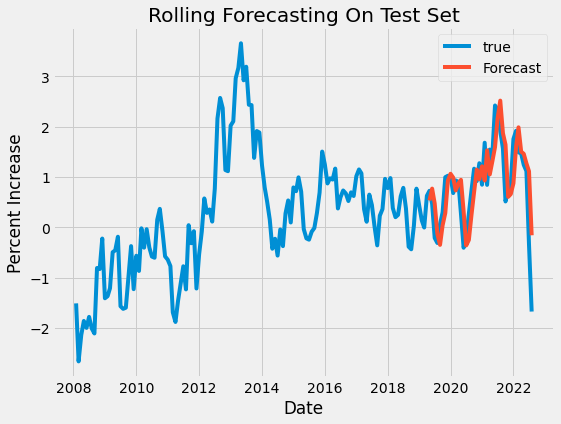

In [47]:
rmse_2 = test_RMSE(sel_df2, pdq, SPDQ)

 zip 3

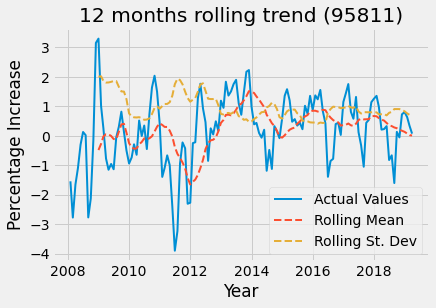

In [49]:
plot_moving_avg(sel_df3[:-40], 12, zip_3)

In [50]:
run_dickey_fuller(sel_df3[:-40], zip_3)

Null Rejected (p = 0.0445). 95811 time series is stationary


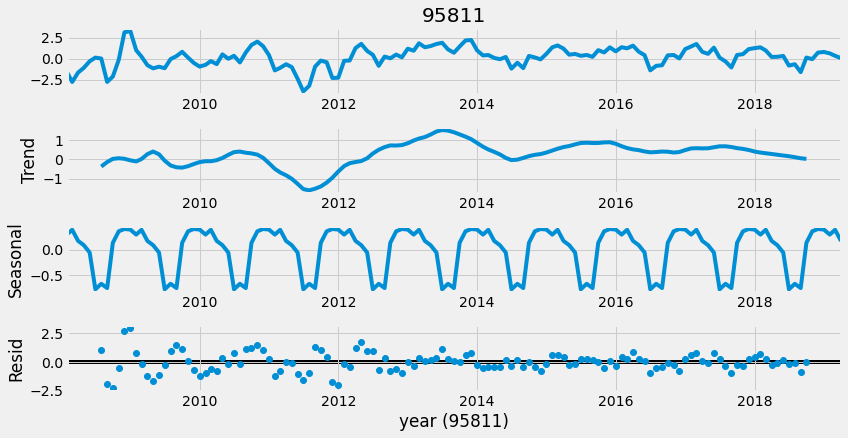

In [51]:
plot_decomposition(sel_df3[:-40], zip_3)

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


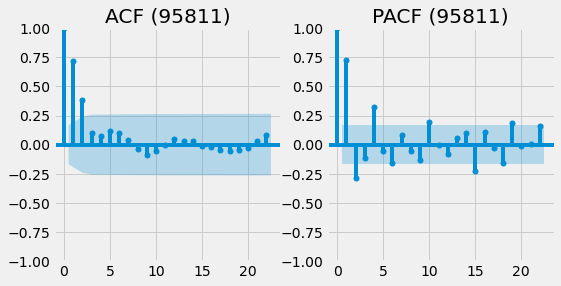

In [52]:
def_acf_pacf(sel_df3[:-40], zip_3)

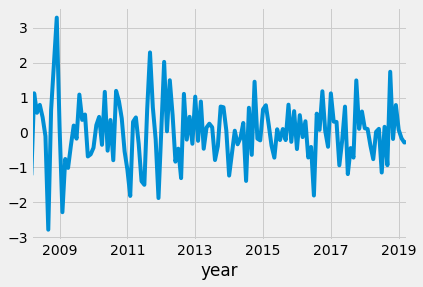

In [53]:
plot_basic(sel_df3[:-40].diff(1)[1:])

In [54]:
run_dickey_fuller(sel_df3[:-40].diff(1)[1:], zip_3)

Null Rejected (p = 0.0). 95811 time series is stationary


In [55]:
pdq, SPDQ = find_sarima_param(sel_df3[:-40])

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


pdq: (1, 0, 1), PDQS: (0, 1, 1, 12) - AIC: 328.48


In [56]:
sarima = SARIMAX(sel_df3[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model3 = sarima.fit()
print(sarima_model3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              95811   No. Observations:                  135
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -128.867
Date:                            Thu, 22 Sep 2022   AIC                            265.734
Time:                                    17:20:37   BIC                            276.499
Sample:                                02-01-2008   HQIC                           270.100
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7008      0.070      9.980      0.000       0.563       0.838
ma.L1          0.0864      0.130   

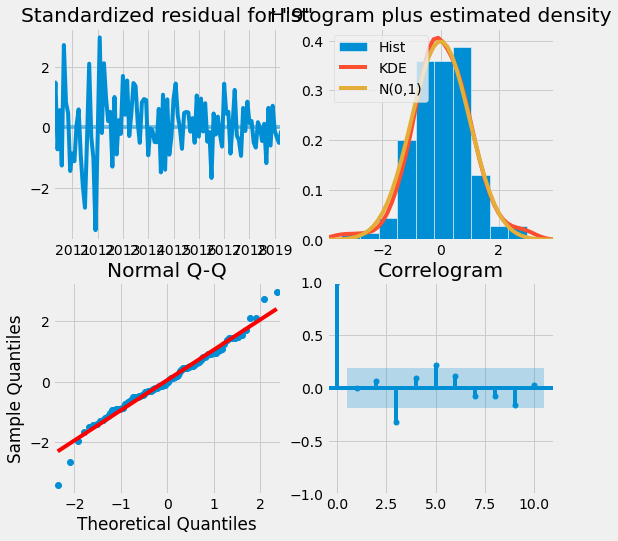

In [57]:
sarima_model3.plot_diagnostics(figsize = (8, 8))
plt.show()

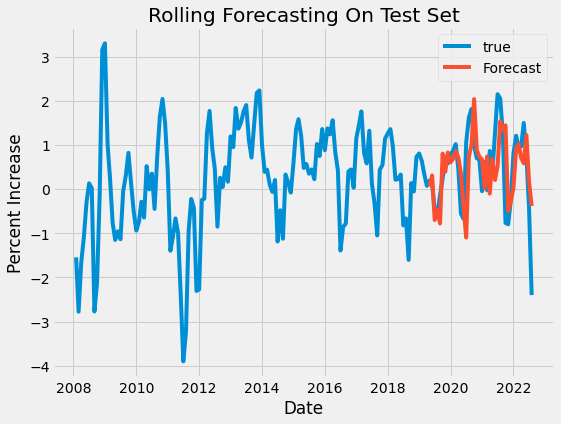

In [58]:
rmse_3= test_RMSE(sel_df3, pdq, SPDQ)

 zip 4

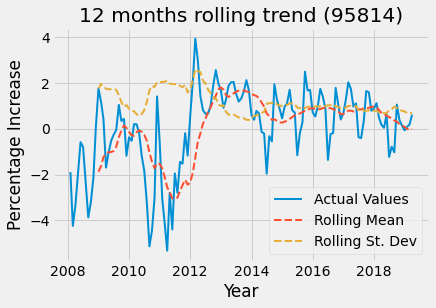

In [59]:
plot_moving_avg(sel_df4[:-40], 12, zip_4)

In [60]:
run_dickey_fuller(sel_df4[:-40], zip_4)

Failed to reject the null (p = 0.2575). 95814 time series is not stationary


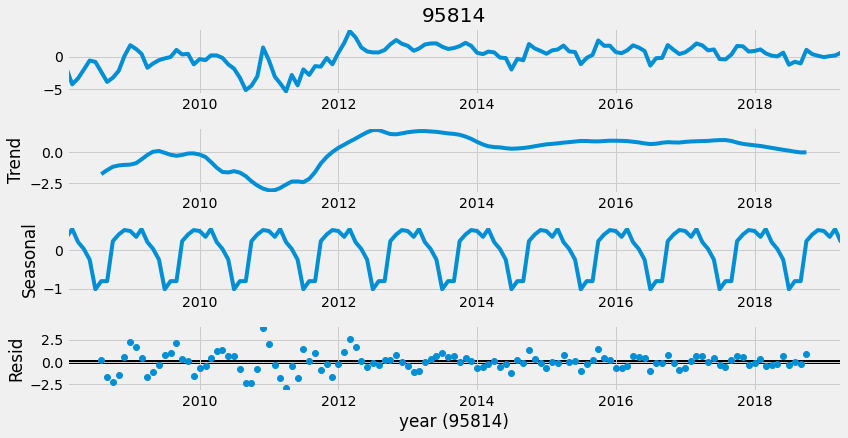

In [61]:
plot_decomposition(sel_df4[:-40], zip_4)

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


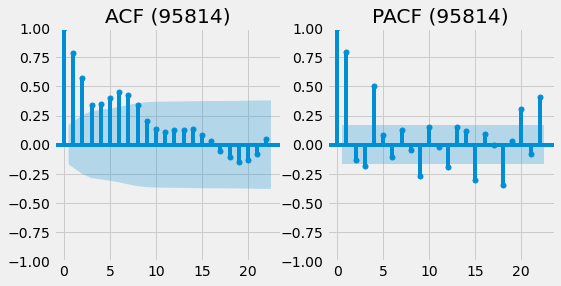

In [62]:
def_acf_pacf(sel_df4[:-40], zip_4)

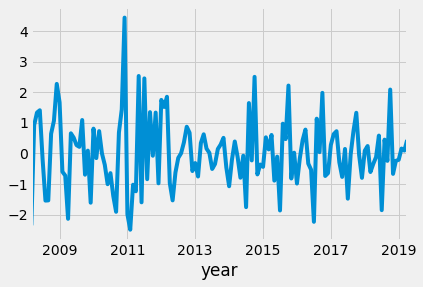

In [63]:
plot_basic(sel_df4[:-40].diff(1)[1:])

In [64]:
run_dickey_fuller(sel_df4[:-40].diff(1)[1:], zip_4)

Null Rejected (p = 0.0391). 95814 time series is stationary


In [65]:
pdq, SPDQ = find_sarima_param(sel_df4[:-40])

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


pdq: (1, 0, 0), PDQS: (1, 1, 1, 12) - AIC: 382.05


In [66]:
sarima = SARIMAX(sel_df4[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model4 = sarima.fit()
print(sarima_model4.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                95814   No. Observations:                  135
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -161.870
Date:                              Thu, 22 Sep 2022   AIC                            331.739
Time:                                      17:21:37   BIC                            342.541
Sample:                                  02-01-2008   HQIC                           336.121
                                       - 04-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8265      0.048     17.233      0.000       0.733       0.921
ar.S.L12      -0.43

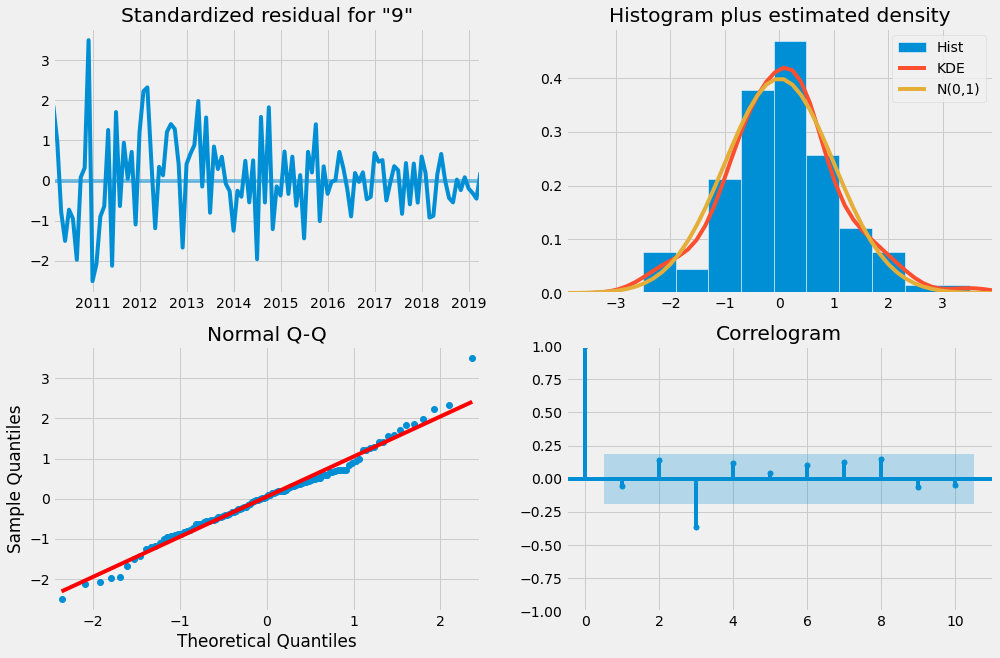

In [67]:
sarima_model4.plot_diagnostics(figsize = (15, 10))
plt.show()

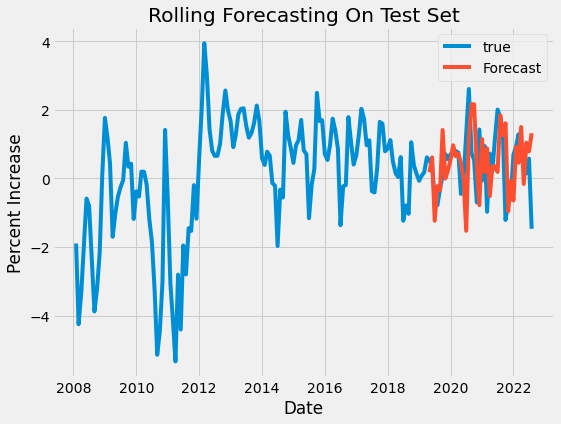

In [68]:
rmse_4 = test_RMSE(sel_df4, pdq, SPDQ)

 zip code 5

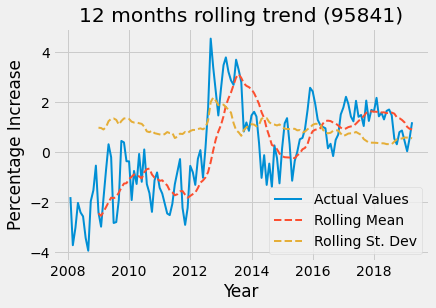

In [69]:
plot_moving_avg(sel_df5[:-40], 12, zip_5)

In [70]:
run_dickey_fuller(sel_df5[:-40], zip_5)

Failed to reject the null (p = 0.3288). 95841 time series is not stationary


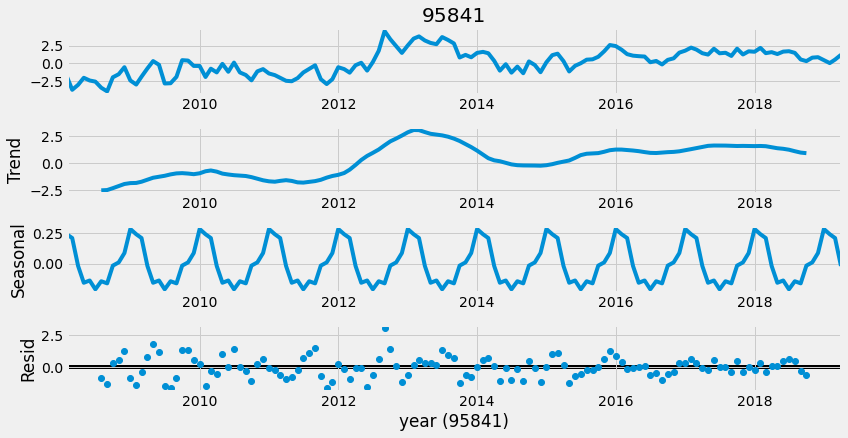

In [71]:
plot_decomposition(sel_df5[:-40], zip_5)

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


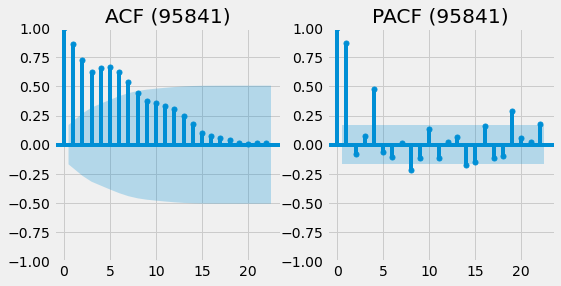

In [72]:
def_acf_pacf(sel_df5[:-40], zip_5)

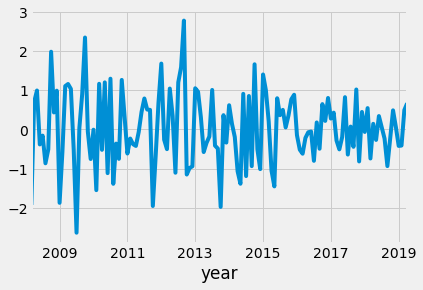

In [73]:
plot_basic(sel_df5[:-40].diff(1)[1:])

In [74]:
run_dickey_fuller(sel_df5[:-40].diff(1)[1:], zip_5)

Null Rejected (p = 0.0). 95841 time series is stationary


In [75]:
pdq, SPDQ = find_sarima_param(sel_df5[:-40])

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


pdq: (1, 1, 1), PDQS: (1, 0, 1, 12) - AIC: 352.37


In [76]:
sarima = SARIMAX(sel_df5[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model5 = sarima.fit()
print(sarima_model5.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              95841   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -150.767
Date:                            Thu, 22 Sep 2022   AIC                            311.534
Time:                                    17:22:33   BIC                            325.471
Sample:                                02-01-2008   HQIC                           317.194
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4800      0.208      2.305      0.021       0.072       0.888
ma.L1         -1.4514      0.386   

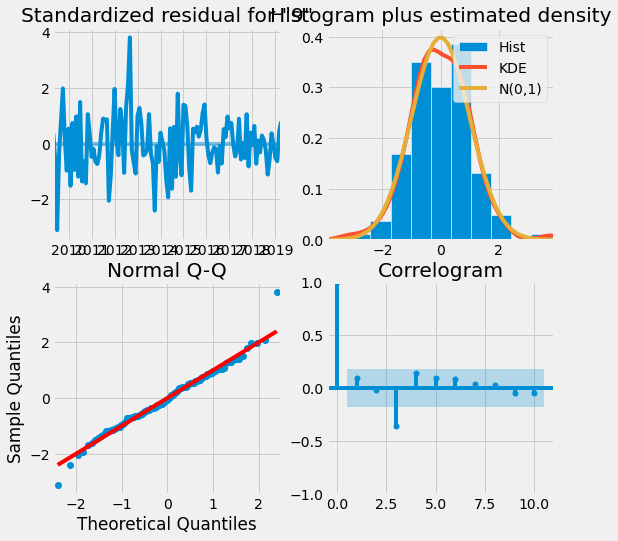

In [77]:
sarima_model5.plot_diagnostics(figsize = (8, 8))
plt.show()

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


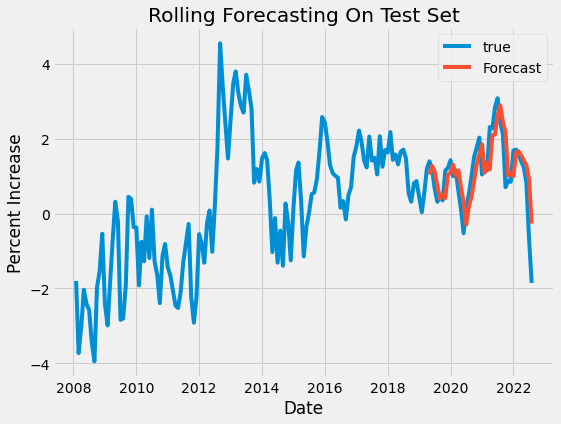

In [78]:
rmse_5 = test_RMSE(sel_df5, pdq, SPDQ)

In [79]:
results['SARIMA'] = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]